In [1]:
import pandas as pd
import os

# File path
file_path = os.path.join("./", "superstore_train.csv")

# Load the dataset with encoding fix
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Fix data types
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

categorical_cols = ['Category', 'Sub-Category', 'Segment', 'Region', 'Ship Mode', 'City', 'State', 'Country']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Quick preview
print(df.dtypes)
df.head()


Row ID                         int64
Order ID                      object
Order Date            datetime64[ns]
Ship Date             datetime64[ns]
Ship Mode                   category
Customer ID                   object
Customer Name                 object
Segment                     category
Country                     category
City                        category
State                       category
Postal Code                    int64
Region                      category
Product ID                    object
Category                    category
Sub-Category                category
Product Name                  object
Sales                        float64
Quantity                       int64
Discount                     float64
Profit                       float64
Shipping Delay                 int64
Discount Binned               object
Discounted Revenue           float64
Profit Margin                float64
dtype: object


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Delay,Discount Binned,Discounted Revenue,Profit Margin
0,4101,US-2017-102288,2017-06-19,2017-06-23,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,...,Appliances,Holmes Visible Mist Ultrasonic Humidifier with...,2.264,1,0.8,-5.2072,4,41-100%,0.4528,-2.300
1,2587,CA-2017-131695,2017-06-30,2017-07-06,Standard Class,RA-19285,Ralph Arnett,Consumer,United States,New York City,...,Storage,Steel Personal Filing/Posting Tote,248.570,7,0.0,67.1139,6,No Discount,248.5700,0.270
2,9195,CA-2014-146843,2014-11-30,2014-12-06,Standard Class,PB-19150,Philip Brown,Consumer,United States,Avondale,...,Supplies,Acme Office Executive Series Stainless Steel T...,47.992,7,0.2,3.5994,6,11-20%,38.3936,0.075
3,2003,CA-2017-163510,2017-12-25,2017-12-28,Second Class,JW-15955,Joni Wasserman,Consumer,United States,Louisville,...,Storage,Fellowes Bankers Box Stor/Drawer Steel Plus,95.940,3,0.0,9.5940,3,No Discount,95.9400,0.100
4,7226,CA-2016-109953,2016-07-14,2016-07-18,Standard Class,RB-19360,Raymond Buch,Consumer,United States,San Francisco,...,Furnishings,Deflect-O Glasstique Clear Desk Accessories,30.800,4,0.0,10.1640,4,No Discount,30.8000,0.330


In [2]:
# Drop identifier and non-predictive columns
columns_to_drop = [
    'Row ID', 
    'Order ID', 
    'Customer ID', 
    'Customer Name', 
    'Product ID', 
    'Product Name'
]

# Drop Country only if it has a single unique value
if df['Country'].nunique() == 1:
    columns_to_drop.append('Country')

df.drop(columns=columns_to_drop, inplace=True)

# Confirm the drop
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'City', 'State',
       'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Discounted Revenue', 'Profit Margin'],
      dtype='object')


In [3]:
import holidays
from datetime import timedelta

# Step 1: Extract time-based features
df['Order Month'] = df['Order Date'].dt.month_name().astype('category')
df['Order Quarter'] = df['Order Date'].dt.quarter.astype('category')
df['Order DayOfWeek'] = df['Order Date'].dt.day_name().astype('category')
df['Order Year'] = df['Order Date'].dt.year.astype('category')

# Step 2: Create custom list of discount-relevant US holidays
years = [2014, 2015, 2016, 2017]
us_holidays = holidays.US(years=years)

# Start with standard holidays relevant to retail
important_holidays = []

for date, name in us_holidays.items():
    if name in [
        "New Year's Day",
        "Presidents' Day",
        "Memorial Day",
        "Independence Day",
        "Labor Day",
        "Thanksgiving",
        "Christmas Day"
    ]:
        important_holidays.append(date)

# Add manually relevant retail dates
for y in years:
    important_holidays.append(pd.Timestamp(f"{y}-12-24"))  # Christmas Eve
    important_holidays.append(pd.Timestamp(f"{y}-12-31"))  # New Year's Eve

# Add Black Friday & Cyber Monday (based on Thanksgiving)
for date, name in us_holidays.items():
    if name == "Thanksgiving":
        black_friday = date + timedelta(days=1)
        cyber_monday = date + timedelta(days=4)
        important_holidays.extend([black_friday, cyber_monday])

# Step 3: Create holiday flag
important_holidays_str = set([d.strftime('%Y-%m-%d') for d in important_holidays])

df['Is Holiday Week'] = df['Order Date'].dt.strftime('%Y-%m-%d').isin(important_holidays_str)
df['Is Holiday Week'] = df['Is Holiday Week'].map({True: 'Yes', False: 'No'}).astype('category')

# Step 4: Drop raw date columns
df.drop(['Order Date', 'Ship Date'], axis=1, inplace=True)

# Step 5: Confirm result
print(df[['Order Month', 'Order DayOfWeek', 'Order Year', 'Is Holiday Week']].head())


  Order Month Order DayOfWeek Order Year Is Holiday Week
0        June          Monday       2017              No
1        June          Friday       2017              No
2    November          Sunday       2014              No
3    December          Monday       2017             Yes
4        July        Thursday       2016              No


In [4]:
# Define new file name and path
output_file = os.path.join("./", "superstore_modified_before_encoding.csv")

# Save to CSV (without the index column)
df.to_csv(output_file, index=False)

print(f"Modified dataset saved to: {output_file}")


Modified dataset saved to: ./superstore_modified_before_encoding.csv


In [5]:
df.dtypes
df.select_dtypes(include='category').columns.tolist()
for col in df.select_dtypes(include='category').columns:
    print(f"\n{col} — {df[col].nunique()} unique values")
    print(df[col].value_counts().head(10))



Ship Mode — 4 unique values
Ship Mode
Standard Class    4796
Second Class      1542
First Class       1225
Same Day           432
Name: count, dtype: int64

Segment — 3 unique values
Segment
Consumer       4170
Corporate      2427
Home Office    1398
Name: count, dtype: int64

City — 515 unique values
City
New York City    723
Los Angeles      594
Philadelphia     439
San Francisco    410
Seattle          355
Houston          299
Chicago          252
Columbus         172
San Diego        132
Springfield      132
Name: count, dtype: int64

State — 49 unique values
State
California        1579
New York           891
Texas              790
Pennsylvania       481
Washington         421
Illinois           402
Ohio               375
Florida            292
Michigan           203
North Carolina     193
Name: count, dtype: int64

Region — 4 unique values
Region
West       2554
East       2283
Central    1867
South      1291
Name: count, dtype: int64

Category — 3 unique values
Category
Office 

In [6]:
# Drop high-cardinality and overly granular columns and Is Holiday Week
df.drop(columns=['City', 'State', 'Sub-Category', 'Postal Code','Is Holiday Week'], inplace=True)

# Confirm drop
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Ship Mode', 'Segment', 'Region', 'Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Discounted Revenue', 'Profit Margin', 'Order Month', 'Order Quarter',
       'Order DayOfWeek', 'Order Year'],
      dtype='object')


In [7]:
missing = df.isnull().sum()
print(missing[missing > 0])

Series([], dtype: int64)


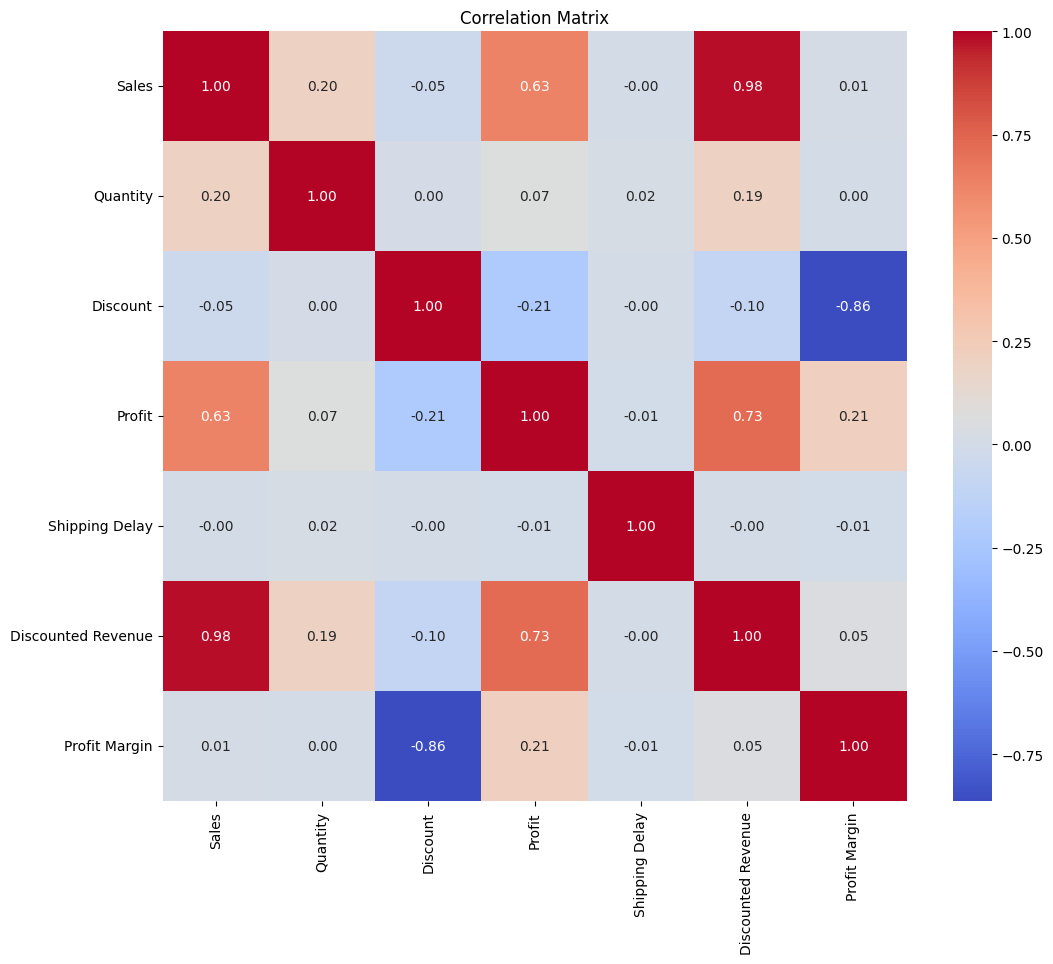

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


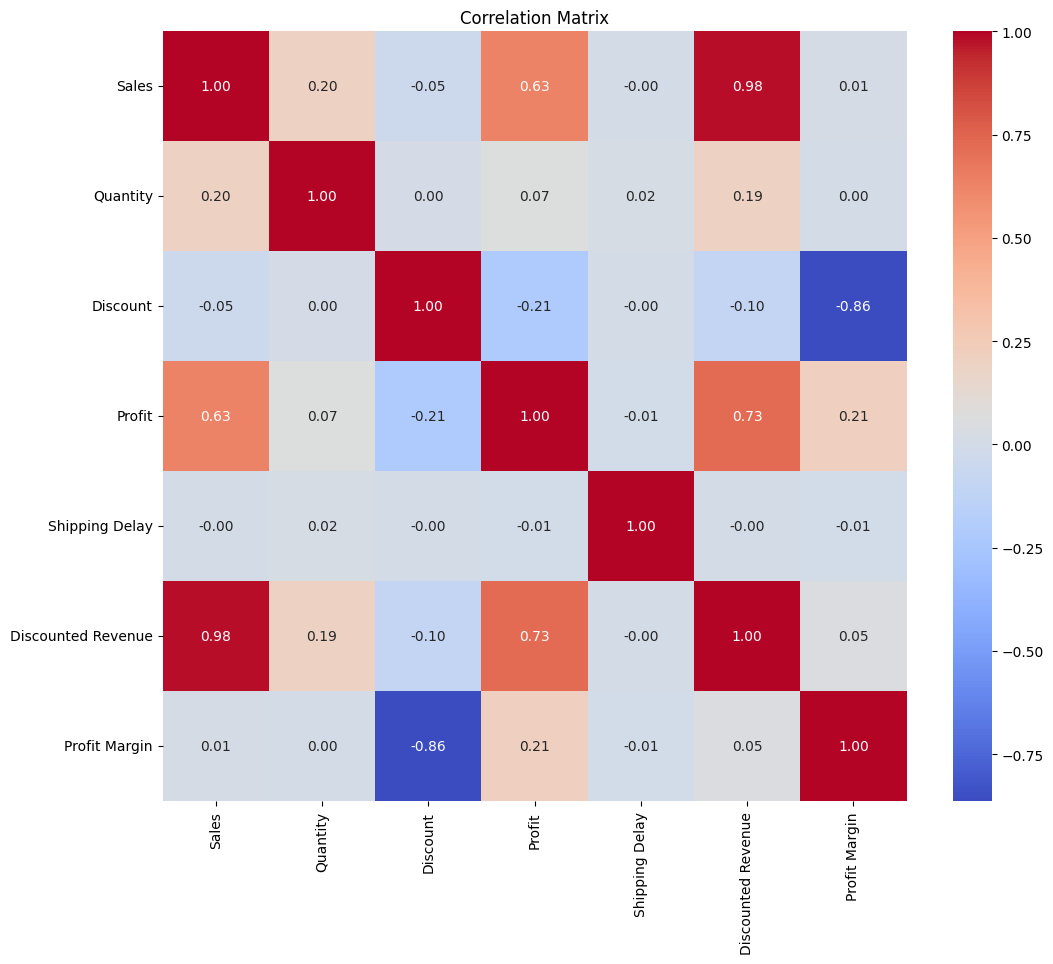


Highly Correlated Pairs (|r| > 0.8):
   Variable 1          Variable 2  Correlation
5       Sales  Discounted Revenue     0.983751
20   Discount       Profit Margin     0.864186


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute correlation matrix (numerical columns only)
corr_matrix = df.corr(numeric_only=True)

# Step 2: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Step 3: Extract pairs with correlation > 0.8 (and not 1.0)
# Stack the matrix, reset index, and rename columns
high_corr = corr_matrix.abs().stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Remove self-pairs and keep only one direction
high_corr = high_corr[high_corr['Variable 1'] != high_corr['Variable 2']]
high_corr = high_corr[high_corr['Correlation'] > 0.8]

# Drop duplicate pairs (A-B vs B-A)
high_corr['Pair'] = high_corr.apply(lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1)
high_corr = high_corr.drop_duplicates(subset='Pair').drop(columns='Pair')

# Sort and display
high_corr = high_corr.sort_values(by='Correlation', ascending=False)
print("\nHighly Correlated Pairs (|r| > 0.8):")
print(high_corr)


In [10]:
# Drop derived/redundant columns
df.drop(columns=['Discounted Revenue', 'Profit Margin'], inplace=True)

# Confirm
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Ship Mode', 'Segment', 'Region', 'Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Order Month', 'Order Quarter', 'Order DayOfWeek', 'Order Year'],
      dtype='object')


In [11]:
# Step 0: Convert any object/bool columns meant for encoding to category
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        df[col] = df[col].astype('category')

# Step 1: Identify categorical columns again
categorical_cols = df.select_dtypes(include='category').columns.tolist()

# Show their data types and unique value counts
for col in categorical_cols:
    print(f"\n🔍 {col} — {df[col].dtype} — {df[col].nunique()} unique values")
    print(df[col].unique())

# Step 2: One-hot encode with forced integer output (VIF-safe)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# Step 3: Confirm final result
print(f"Shape after encoding: {df.shape}")
print("Column types after encoding:")
print(df.dtypes.value_counts())



🔍 Ship Mode — category — 4 unique values
['Standard Class', 'Second Class', 'First Class', 'Same Day']
Categories (4, object): ['First Class', 'Same Day', 'Second Class', 'Standard Class']

🔍 Segment — category — 3 unique values
['Consumer', 'Corporate', 'Home Office']
Categories (3, object): ['Consumer', 'Corporate', 'Home Office']

🔍 Region — category — 4 unique values
['Central', 'East', 'West', 'South']
Categories (4, object): ['Central', 'East', 'South', 'West']

🔍 Category — category — 3 unique values
['Office Supplies', 'Furniture', 'Technology']
Categories (3, object): ['Furniture', 'Office Supplies', 'Technology']

🔍 Discount Binned — category — 6 unique values
['41-100%', 'No Discount', '11-20%', '31-40%', '21-30%', '0-10%']
Categories (6, object): ['0-10%', '11-20%', '21-30%', '31-40%', '41-100%', 'No Discount']

🔍 Order Month — category — 12 unique values
['June', 'November', 'December', 'July', 'September', ..., 'October', 'May', 'August', 'January', 'February']
Length: 1

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop the target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add a constant for the intercept
X = add_constant(X)

# Step 3: Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Round and sort VIF values
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Variance Inflation Factors (VIF):")
print(vif_data)


C:\Users\chait\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\chait\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🔍 Variance Inflation Factors (VIF):
                        Feature    VIF
32              Order Quarter_3    inf
30        Order Month_September    inf
31              Order Quarter_2    inf
28         Order Month_November    inf
29          Order Month_October    inf
20           Order Month_August    inf
21         Order Month_December    inf
26            Order Month_March    inf
24             Order Month_July    inf
22         Order Month_February    inf
23          Order Month_January    inf
33              Order Quarter_4    inf
3                      Discount  60.19
18      Discount Binned_41-100%  51.25
19  Discount Binned_No Discount  31.89
15       Discount Binned_11-20%  28.34
17       Discount Binned_31-40%   6.10
16       Discount Binned_21-30%   4.51
7      Ship Mode_Standard Class   3.97
4                Shipping Delay   3.16
6        Ship Mode_Second Class   2.01
27              Order Month_May   2.00
25             Order Month_June   1.95
13     Category_Office Suppl

In [13]:
# Drop one-hot encoded Order Quarter columns
quarter_cols = [col for col in df.columns if col.startswith('Order Quarter_')]
df.drop(columns=quarter_cols, inplace=True)

# Confirm drop
print("Dropped columns:", quarter_cols)


Dropped columns: ['Order Quarter_2', 'Order Quarter_3', 'Order Quarter_4']


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add constant
X = add_constant(X)

# Step 3: Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Clean output
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Updated VIF after dropping Order Quarter:")
print(vif_data)


🔍 Updated VIF after dropping Order Quarter:
                        Feature     VIF
0                         const  162.59
3                      Discount   60.19
18      Discount Binned_41-100%   51.25
19  Discount Binned_No Discount   31.89
15       Discount Binned_11-20%   28.34
17       Discount Binned_31-40%    6.10
16       Discount Binned_21-30%    4.51
7      Ship Mode_Standard Class    3.97
4                Shipping Delay    3.16
28         Order Month_November    2.77
21         Order Month_December    2.74
30        Order Month_September    2.71
29          Order Month_October    2.08
6        Ship Mode_Second Class    2.01
27              Order Month_May    2.00
24             Order Month_July    1.96
25             Order Month_June    1.95
20           Order Month_August    1.94
26            Order Month_March    1.94
13     Category_Office Supplies    1.93
39              Order Year_2017    1.88
38              Order Year_2016    1.80
12                  Region_West    1

In [15]:
# Drop all Discount Binned dummy variables
discount_bin_cols = [col for col in df.columns if col.startswith('Discount Binned_')]
df.drop(columns=discount_bin_cols, inplace=True)

# Confirm
print("Dropped columns:", discount_bin_cols)


Dropped columns: ['Discount Binned_11-20%', 'Discount Binned_21-30%', 'Discount Binned_31-40%', 'Discount Binned_41-100%', 'Discount Binned_No Discount']


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add constant
X = add_constant(X)

# Step 3: Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Clean output
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Updated VIF after dropping Order Quarter:")
print(vif_data)


🔍 Updated VIF after dropping Order Quarter:
                      Feature    VIF
0                       const  48.79
7    Ship Mode_Standard Class   3.97
4              Shipping Delay   3.16
23       Order Month_November   2.77
16       Order Month_December   2.73
25      Order Month_September   2.71
24        Order Month_October   2.08
6      Ship Mode_Second Class   2.01
22            Order Month_May   2.00
20           Order Month_June   1.95
19           Order Month_July   1.95
15         Order Month_August   1.94
21          Order Month_March   1.94
34            Order Year_2017   1.88
33            Order Year_2016   1.80
12                Region_West   1.72
32            Order Year_2015   1.71
26     Order DayOfWeek_Monday   1.66
10                Region_East   1.65
28     Order DayOfWeek_Sunday   1.64
27   Order DayOfWeek_Saturday   1.61
29   Order DayOfWeek_Thursday   1.58
13   Category_Office Supplies   1.57
14        Category_Technology   1.54
5          Ship Mode_Same Day  

In [17]:
import statsmodels.api as sm

# Step 1: Define target and features
y = df['Profit']
X = df.drop(columns=['Profit'])

# Step 2: Add constant for intercept
X = sm.add_constant(X)

# Step 3: Fit the OLS model
model = sm.OLS(y, X).fit()

# Step 4: View model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 16 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:24:48   Log-Likelihood:                -52710.
No. Observations:                7995   AIC:                         1.055e+05
Df Residuals:                    7960   BIC:                         1.057e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

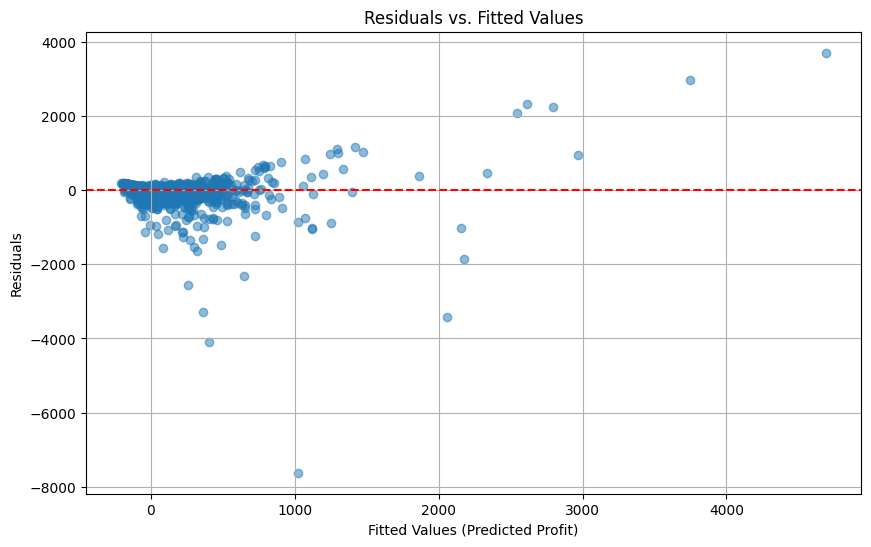

In [18]:
import matplotlib.pyplot as plt

# Get residuals and fitted values
fitted_vals = model.fittedvalues
residuals = model.resid

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Profit)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.grid(True)
plt.show()


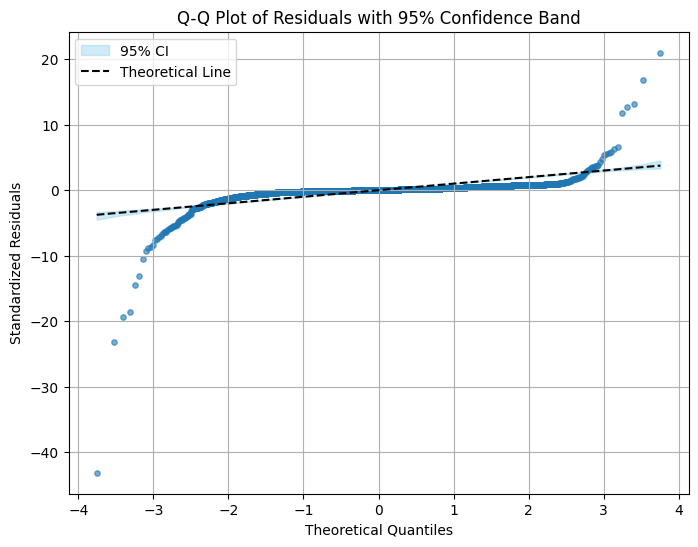

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Normalize residuals
residuals = model.resid
residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Get theoretical quantiles and ordered residuals
theoretical_q, sample_q = stats.probplot(residuals, dist="norm")

# Bootstrap for envelope
n = len(residuals)
simulated = np.array([np.sort(np.random.normal(size=n)) for _ in range(100)])
lower = np.percentile(simulated, 2.5, axis=0)
upper = np.percentile(simulated, 97.5, axis=0)

# Plot
plt.figure(figsize=(8, 6))
plt.fill_between(theoretical_q[0], lower, upper, color='skyblue', alpha=0.4, label='95% CI')
plt.plot(theoretical_q[0], theoretical_q[0], color='black', linestyle='--', label='Theoretical Line')
plt.scatter(theoretical_q[0], theoretical_q[1], alpha=0.6, s=15)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.title('Q-Q Plot of Residuals with 95% Confidence Band')
plt.legend()
plt.grid(True)
plt.show()


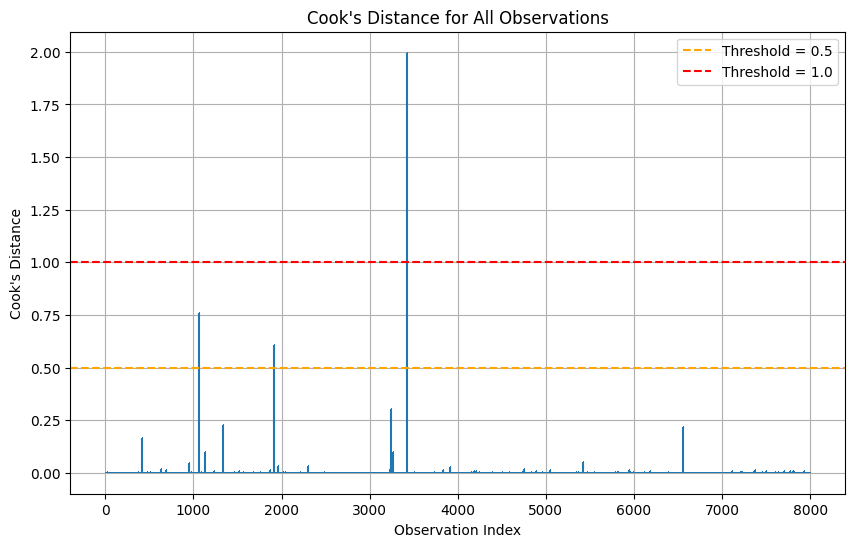

Number of highly influential points (Cook's D > 1): 1
Indices of most influential observations: [3429]


,Sales,Quantity,Discount,Profit,Shipping Delay,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Order Month_September,Order DayOfWeek_Monday,Order DayOfWeek_Saturday,Order DayOfWeek_Sunday,Order DayOfWeek_Thursday,Order DayOfWeek_Tuesday,Order DayOfWeek_Wednesday,Order Year_2015,Order Year_2016,Order Year_2017
3429,17499.95,5,0.0,8399.976,7,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0


In [20]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get influence measures
influence = model.get_influence()

# Step 2: Extract Cook’s Distance and leverage
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag

# Step 3: Plot Cook’s Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(y=0.5, color='orange', linestyle='--', label="Threshold = 0.5")
plt.axhline(y=1.0, color='red', linestyle='--', label="Threshold = 1.0")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for All Observations")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Find most influential observations
influential_points = np.where(cooks_d > 1)[0]
print(f"Number of highly influential points (Cook's D > 1): {len(influential_points)}")
print("Indices of most influential observations:", influential_points[:10])  # preview first 10
df.iloc[influential_points]  # This will show you the full rows


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Create a copy of df and remove the Sales column
df_restricted = df.copy()
if 'Sales' in df_restricted.columns:
    df_restricted = df_restricted.drop(columns=['Sales'])

# Convert categorical variables to dummy/indicator variables
df_restricted = pd.get_dummies(df_restricted, drop_first=True)

# Define the target variable and predictors for the restricted model
y_restricted = df_restricted['Profit']
X_restricted = df_restricted.drop('Profit', axis=1)

# Split the data into training and testing sets
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_restricted, y_restricted, test_size=0.2, random_state=42)

# Fit a Random Forest model on the restricted data (using tuned parameters from earlier)
rf_restricted = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
rf_restricted.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred_res = rf_restricted.predict(X_test_res)

# Evaluate model performance using R² and RMSE
r2_res = r2_score(y_test_res, y_pred_res)
rmse_res = np.sqrt(mean_squared_error(y_test_res, y_pred_res))
print(f"Restricted Random Forest Model (without Sales) - R²: {r2_res:.3f}, RMSE: {rmse_res:.3f}")

# Optionally, perform cross-validation to assess model stability
cv_scores_res = cross_val_score(rf_restricted, X_restricted, y_restricted, cv=5, scoring='r2')
print("Restricted Model Cross-validated R² scores:", cv_scores_res)
print("Restricted Model Mean CV R²:", cv_scores_res.mean())


Restricted Random Forest Model (without Sales) - R²: -0.673, RMSE: 181.075
Restricted Model Cross-validated R² scores: [ 0.01217665 -0.08216532  0.04068482 -0.59296378 -0.05989906]
Restricted Model Mean CV R²: -0.1364333396089677


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Print the columns to see what's available
print("Columns in df:", df.columns.tolist())

# Define the columns you want to drop
drop_cols = ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 
             'Customer Name', 'Country', 'City', 'State', 'Postal Code', 
             'Product ID', 'Product Name', 'Discount Binned']

# Filter the drop list to include only columns that exist in df
existing_drop_cols = [col for col in drop_cols if col in df.columns]
print("Dropping columns:", existing_drop_cols)

# Drop the existing columns
df_model = df.drop(columns=existing_drop_cols)

# Convert categorical variables to dummy variables
df_model = pd.get_dummies(df_model, drop_first=True)

# Define the target variable and predictors
y = df_model['Profit']
X = df_model.drop('Profit', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model performance using R^2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest Model - R^2: {r2:.3f}, RMSE: {rmse:.3f}")

# Optionally, perform cross-validation to assess model stability
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", cv_scores)
print("Mean CV R^2:", cv_scores.mean())


Columns in df: ['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Delay', 'Ship Mode_Same Day', 'Ship Mode_Second Class', 'Ship Mode_Standard Class', 'Segment_Corporate', 'Segment_Home Office', 'Region_East', 'Region_South', 'Region_West', 'Category_Office Supplies', 'Category_Technology', 'Order Month_August', 'Order Month_December', 'Order Month_February', 'Order Month_January', 'Order Month_July', 'Order Month_June', 'Order Month_March', 'Order Month_May', 'Order Month_November', 'Order Month_October', 'Order Month_September', 'Order DayOfWeek_Monday', 'Order DayOfWeek_Saturday', 'Order DayOfWeek_Sunday', 'Order DayOfWeek_Thursday', 'Order DayOfWeek_Tuesday', 'Order DayOfWeek_Wednesday', 'Order Year_2015', 'Order Year_2016', 'Order Year_2017']
Dropping columns: []
Random Forest Model - R^2: 0.712, RMSE: 75.104
Cross-validated R^2 scores: [0.8458795  0.21920112 0.6879875  0.82403555 0.8381997 ]
Mean CV R^2: 0.6830606728057141


                      Feature  Importance
0                       Sales    0.801798
2                    Discount    0.116640
1                    Quantity    0.013026
3              Shipping Delay    0.006882
24      Order Month_September    0.006430
12   Category_Office Supplies    0.005021
7           Segment_Corporate    0.004603
18           Order Month_July    0.003967
13        Category_Technology    0.003952
28   Order DayOfWeek_Thursday    0.002943
23        Order Month_October    0.002695
9                 Region_East    0.002534
10               Region_South    0.002419
29    Order DayOfWeek_Tuesday    0.002345
33            Order Year_2017    0.002183
11                Region_West    0.002161
5      Ship Mode_Second Class    0.002082
32            Order Year_2016    0.002018
27     Order DayOfWeek_Sunday    0.001735
21            Order Month_May    0.001722
6    Ship Mode_Standard Class    0.001722
26   Order DayOfWeek_Saturday    0.001494
8         Segment_Home Office    0

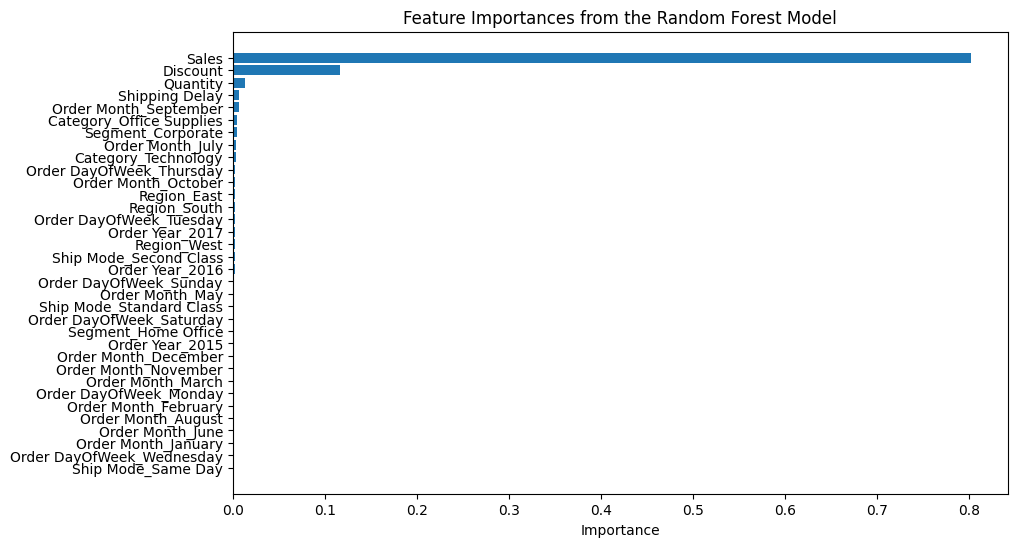

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract and sort feature importances
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from the Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


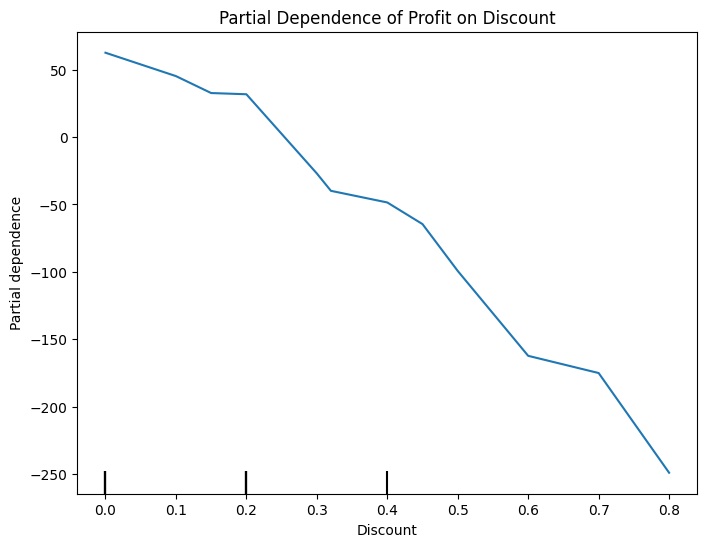

In [27]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Plot partial dependence for the 'Discount' feature
features_to_plot = ['Discount']
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=features_to_plot, grid_resolution=50, ax=ax)
ax.set_title("Partial Dependence of Profit on Discount")
ax.set_xlabel("Discount")
ax.set_ylabel("Predicted Profit")
plt.show()


In [28]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated R²:", grid_search.best_score_)

# Refit model with best parameters and evaluate on test set
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Optimized Random Forest - R²: {r2_best:.3f}, RMSE: {rmse_best:.3f}")


Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated R²: 0.6593099614973738
Optimized Random Forest - R²: 0.700, RMSE: 76.651


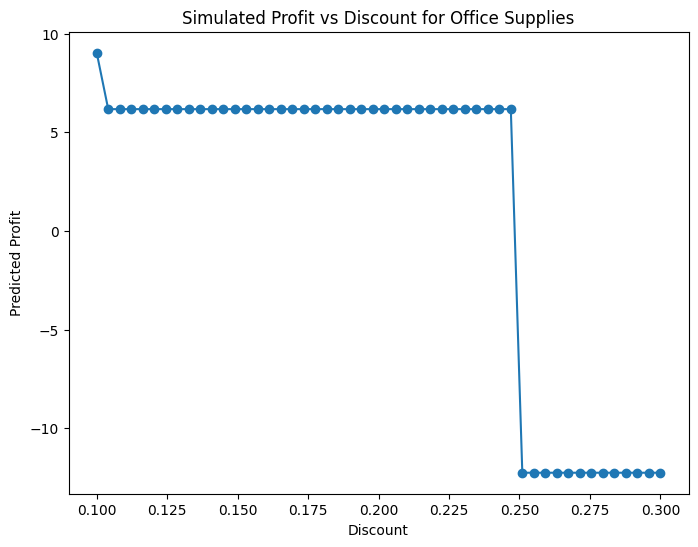

In [29]:
import numpy as np

# Choose a baseline sample from a specific category (e.g., Office Supplies)
baseline_sample = X_train[X_train['Category_Office Supplies'] == 1].iloc[0].copy()

# Create a range of discount values to simulate
discount_range = np.linspace(baseline_sample['Discount'] * 0.5, baseline_sample['Discount'] * 1.5, 50)

# Copy the baseline sample for each discount scenario
simulated_samples = pd.DataFrame([baseline_sample] * len(discount_range))
simulated_samples['Discount'] = discount_range

# Predict profit for each simulated discount level
predicted_profits = best_rf_model.predict(simulated_samples)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(discount_range, predicted_profits, marker='o')
plt.xlabel("Discount")
plt.ylabel("Predicted Profit")
plt.title("Simulated Profit vs Discount for Office Supplies")
plt.show()


Chosen baseline sample:
      Discount  Sales  Profit
7993       0.0   7.36  0.1472


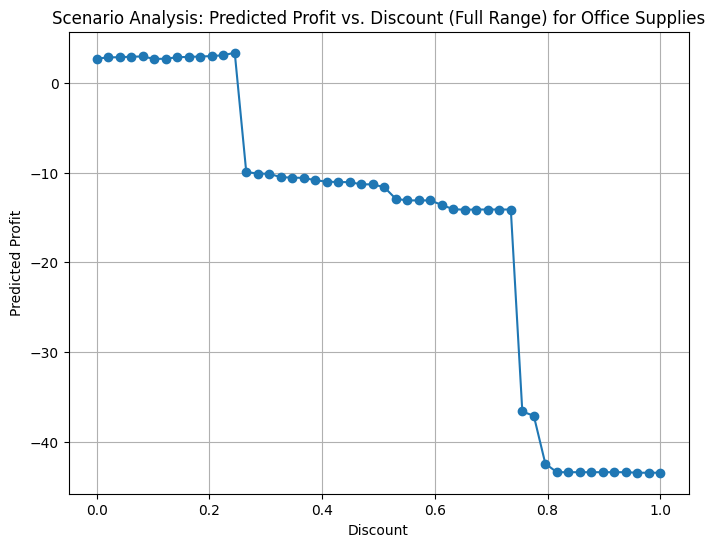

   Discount  Simulated Sales  Predicted Profit
0  0.000000         7.360000          2.688645
1  0.020408         7.660408          2.835285
2  0.040816         7.960816          2.852243
3  0.061224         8.261224          2.912613
4  0.081633         8.561633          2.935953
5  0.102041         8.862041          2.665333
6  0.122449         9.162449          2.681273
7  0.142857         9.462857          2.849903
8  0.163265         9.763265          2.891378
9  0.183673        10.063673          2.930989


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter for Office Supplies category
office_supplies = df[df['Category_Office Supplies'] == 1]

# Calculate the median discount for Office Supplies
median_discount = office_supplies['Discount'].median()

# Find the row closest to the median discount
baseline_sample = office_supplies.iloc[(office_supplies['Discount'] - median_discount).abs().argsort()[:1]].copy()

print("Chosen baseline sample:")
print(baseline_sample[['Discount', 'Sales', 'Profit']])

# Extract baseline discount and sales values
baseline_discount = baseline_sample['Discount'].iloc[0]
baseline_sales = baseline_sample['Sales'].iloc[0]

# Define the full range of discount values from 0 to 1
discount_range = np.linspace(0, 1, 50)

# Calculate the difference from the baseline discount
delta = discount_range - baseline_discount

# Apply an elasticity assumption:
# For every 0.01 increase in discount above baseline, sales increase by 2% relative to baseline sales.
# (For discounts below baseline, sales decrease proportionally.)
simulated_sales = baseline_sales * (1 + 2 * delta)

# Create a DataFrame that replicates the baseline sample for each simulated scenario
simulated_samples = pd.DataFrame([baseline_sample.iloc[0]] * len(discount_range))
simulated_samples['Discount'] = discount_range
simulated_samples['Sales'] = simulated_sales

# Remove the target column (Profit) so that only predictors remain
predictors = simulated_samples.drop('Profit', axis=1)

# Use your full model (best_rf_model) to predict profit for each simulated scenario
predicted_profit = best_rf_model.predict(predictors)

# Plot the full discount range vs. predicted profit
plt.figure(figsize=(8, 6))
plt.plot(discount_range, predicted_profit, marker='o')
plt.xlabel('Discount')
plt.ylabel('Predicted Profit')
plt.title('Scenario Analysis: Predicted Profit vs. Discount (Full Range) for Office Supplies')
plt.grid(True)
plt.show()

# Optionally, inspect the simulation results
result = pd.DataFrame({
    'Discount': discount_range,
    'Simulated Sales': simulated_sales,
    'Predicted Profit': predicted_profit
})
print(result.head(10))



Chosen baseline sample for Office Supplies:
      Discount  Sales  Profit
7993       0.0   7.36  0.1472


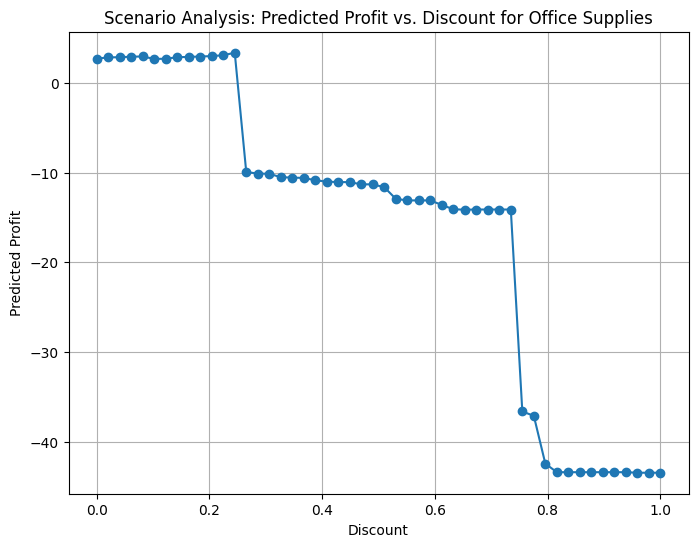

   Discount  Simulated Sales  Predicted Profit
0  0.000000         7.360000          2.688645
1  0.020408         7.660408          2.835285
2  0.040816         7.960816          2.852243
3  0.061224         8.261224          2.912613
4  0.081633         8.561633          2.935953
5  0.102041         8.862041          2.665333
6  0.122449         9.162449          2.681273
7  0.142857         9.462857          2.849903
8  0.163265         9.763265          2.891378
9  0.183673        10.063673          2.930989

Chosen baseline sample for Technology:
      Discount    Sales  Profit
3596       0.2  201.584  12.599


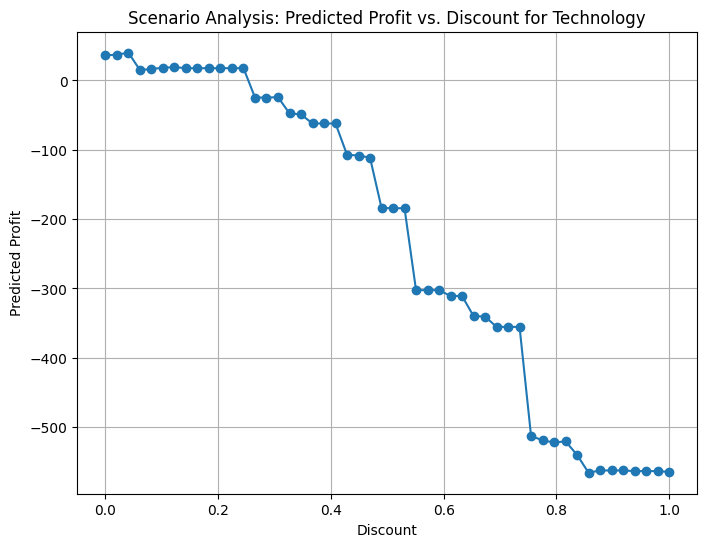

   Discount  Simulated Sales  Predicted Profit
0  0.000000       120.950400         36.190653
1  0.020408       129.178318         37.336965
2  0.040816       137.406237         40.044610
3  0.061224       145.634155         14.965356
4  0.081633       153.862073         16.627507
5  0.102041       162.089992         18.316788
6  0.122449       170.317910         19.303542
7  0.142857       178.545829         17.737578
8  0.163265       186.773747         17.737578
9  0.183673       195.001665         17.737578

Chosen baseline sample for Furniture:
      Discount    Sales  Profit
3950       0.2  585.552  73.194


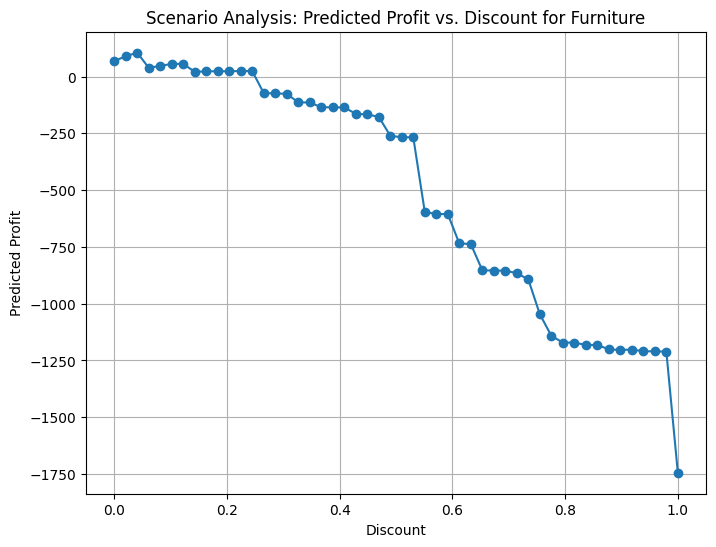

   Discount  Simulated Sales  Predicted Profit
0  0.000000       351.331200         67.891515
1  0.020408       375.231282         89.671750
2  0.040816       399.131363        104.959865
3  0.061224       423.031445         38.807539
4  0.081633       446.931527         46.573696
5  0.102041       470.831608         55.951958
6  0.122449       494.731690         55.682381
7  0.142857       518.631771         21.049722
8  0.163265       542.531853         22.746372
9  0.183673       566.431935         23.432963


,Discount,Simulated Sales,Predicted Profit
0,0.000000,351.331200,67.891515
1,0.020408,375.231282,89.671750
2,0.040816,399.131363,104.959865
3,0.061224,423.031445,38.807539
4,0.081633,446.931527,46.573696
5,0.102041,470.831608,55.951958
6,0.122449,494.731690,55.682381
7,0.142857,518.631771,21.049722
8,0.163265,542.531853,22.746372
9,0.183673,566.431935,23.432963


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_scenario_for_category(category_name, df, best_rf_model, elasticity=2, n_points=50):
    """
    Simulate profit prediction over a full discount range (0 to 1) for a given category.
    
    Parameters:
    - category_name: 'Office Supplies', 'Technology', or 'Furniture'
    - df: the full DataFrame with one-hot encoded columns (including Sales, Discount, Profit, etc.)
    - best_rf_model: the trained full model (Random Forest) that includes Sales
    - elasticity: assumption that for every 0.01 change in discount, sales change by elasticity*100% (e.g., 2 for 2%)
    - n_points: number of simulated discount values in the range [0, 1]
    
    Returns:
    - result: DataFrame containing the simulated discount, adjusted Sales, and predicted Profit.
    """
    # Filter data based on category
    if category_name == 'Office Supplies':
        subset = df[df['Category_Office Supplies'] == 1]
    elif category_name == 'Technology':
        subset = df[df['Category_Technology'] == 1]
    elif category_name == 'Furniture':
        # Furniture is assumed to be the reference: where both Office Supplies and Technology dummies are 0.
        subset = df[(df['Category_Office Supplies'] == 0) & (df['Category_Technology'] == 0)]
    else:
        print("Invalid category name provided.")
        return
    
    if subset.empty:
        print(f"No data found for {category_name}.")
        return
    
    # Select a baseline sample as the row closest to the median discount in the subset
    median_discount = subset['Discount'].median()
    baseline_sample = subset.iloc[(subset['Discount'] - median_discount).abs().argsort()[:1]].copy()
    
    print(f"\nChosen baseline sample for {category_name}:")
    print(baseline_sample[['Discount', 'Sales', 'Profit']])
    
    # Extract baseline discount and sales
    baseline_discount = baseline_sample['Discount'].iloc[0]
    baseline_sales = baseline_sample['Sales'].iloc[0]
    
    # Define full discount range (0 to 1)
    discount_range = np.linspace(0, 1, n_points)
    
    # Compute the difference from baseline discount
    delta = discount_range - baseline_discount
    
    # Adjust Sales based on the elasticity assumption:
    # For every 0.01 increase/decrease in discount, sales change by (elasticity*0.01) relative to baseline.
    simulated_sales = baseline_sales * (1 + elasticity * delta)
    
    # Create simulated samples by replicating the baseline sample and updating Discount and Sales
    simulated_samples = pd.DataFrame([baseline_sample.iloc[0]] * len(discount_range))
    simulated_samples['Discount'] = discount_range
    simulated_samples['Sales'] = simulated_sales
    
    # For prediction, remove the target column (Profit)
    predictors = simulated_samples.drop('Profit', axis=1)
    
    # Predict profit for each scenario using the full model
    predicted_profit = best_rf_model.predict(predictors)
    
    # Plot the simulation results
    plt.figure(figsize=(8, 6))
    plt.plot(discount_range, predicted_profit, marker='o')
    plt.xlabel('Discount')
    plt.ylabel('Predicted Profit')
    plt.title(f'Scenario Analysis: Predicted Profit vs. Discount for {category_name}')
    plt.grid(True)
    plt.show()
    
    # Build a results DataFrame and print the first few rows
    result = pd.DataFrame({
        'Discount': discount_range,
        'Simulated Sales': simulated_sales,
        'Predicted Profit': predicted_profit
    })
    print(result.head(10))
    return result

# Run scenario analysis for each category using your full DataFrame 'df' and your trained model 'best_rf_model'
simulate_scenario_for_category('Office Supplies', df, best_rf_model)
simulate_scenario_for_category('Technology', df, best_rf_model)
simulate_scenario_for_category('Furniture', df, best_rf_model)


In [42]:
import shap
import matplotlib.pyplot as plt

# Initialize the TreeExplainer for your trained Random Forest model
explainer = shap.TreeExplainer(best_rf_model)

# Compute SHAP values for your dataset X (the predictors used for training)
shap_values = explainer.shap_values(X)

# (Optional) Initialize JavaScript visualization in notebooks
shap.initjs()

# Summary plot: shows feature importance and effect across the dataset
shap.summary_plot(shap_values, X)

# Dependence plot for the 'Discount' feature to visualize its impact on predictions
shap.dependence_plot("Discount", shap_values, X)


ModuleNotFoundError: No module named 'shap'

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

# Define the target variable and predictors from your full DataFrame
y = df['Profit']
X = df.drop('Profit', axis=1)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = gb_model.predict(X_test)

# Evaluate model performance using R² and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Gradient Boosting Model - R²: {r2:.3f}, RMSE: {rmse:.3f}")

# Optionally, perform 5-fold cross-validation to assess model stability
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='r2')
print("Gradient Boosting Model Cross-validated R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())


Gradient Boosting Model - R²: 0.719, RMSE: 74.192
Gradient Boosting Model Cross-validated R² scores: [0.85154192 0.42778858 0.72703606 0.88351502 0.81026013]
Mean CV R²: 0.7400283408423697


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define a parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Instantiate the Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV R² score:", grid_search.best_score_)

# Use the best estimator for further analysis
best_gb_model = grid_search.best_estimator_


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best CV R² score: 0.7412179691771897


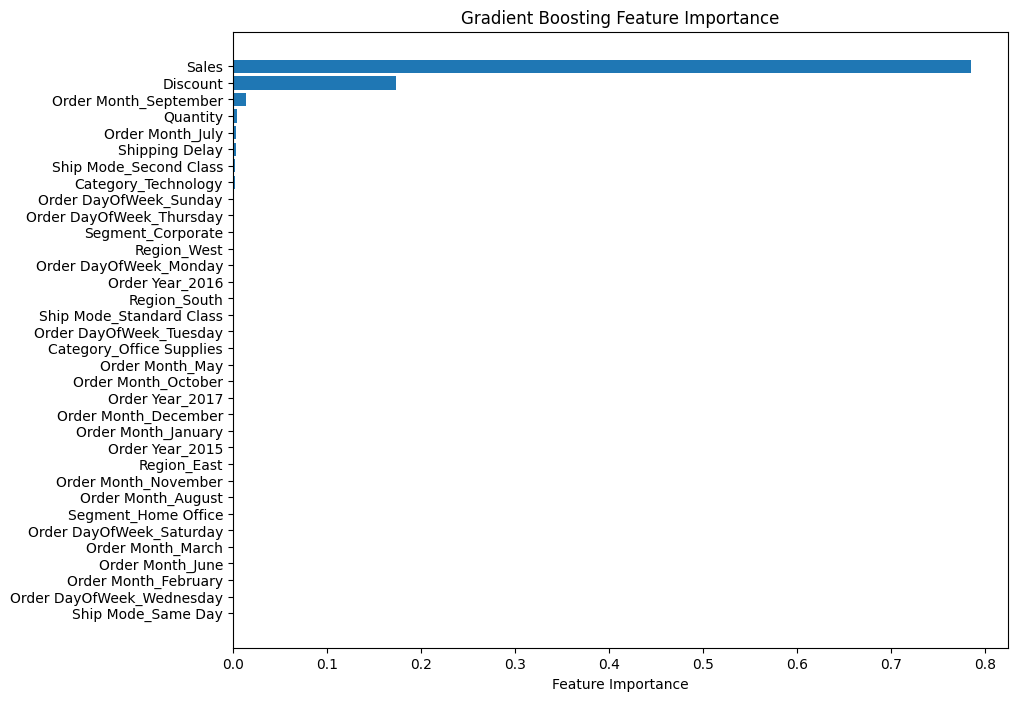

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the tuned model
importances = best_gb_model.feature_importances_
features = X.columns  # 'X' is the predictor DataFrame used for training
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=True, inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()



Chosen baseline sample for Office Supplies:
      Discount  Sales  Profit
7993       0.0   7.36  0.1472


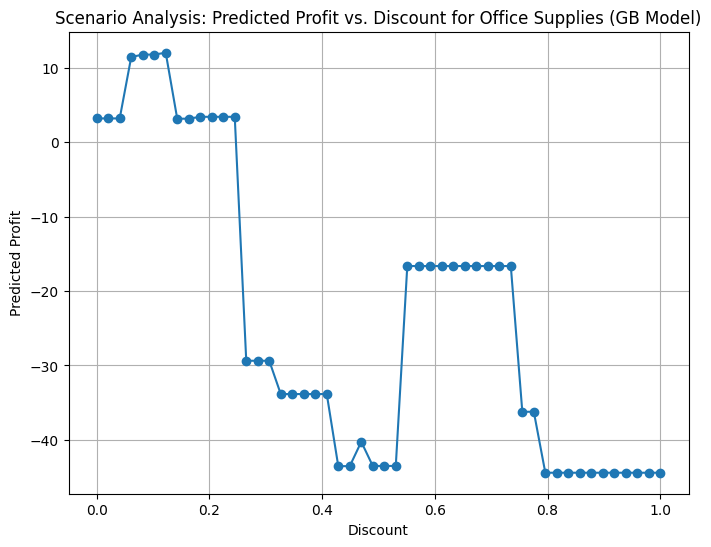

   Discount  Simulated Sales  Predicted Profit
0  0.000000         7.360000          3.216753
1  0.020408         7.660408          3.216753
2  0.040816         7.960816          3.216753
3  0.061224         8.261224         11.470045
4  0.081633         8.561633         11.800268
5  0.102041         8.862041         11.800268
6  0.122449         9.162449         12.050682
7  0.142857         9.462857          3.180577
8  0.163265         9.763265          3.180577
9  0.183673        10.063673          3.434061

Chosen baseline sample for Technology:
      Discount    Sales  Profit
3596       0.2  201.584  12.599


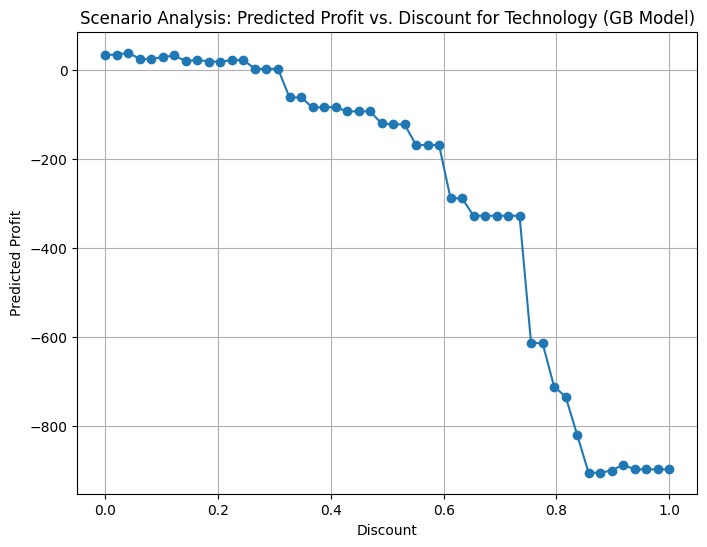

   Discount  Simulated Sales  Predicted Profit
0  0.000000       120.950400         33.655154
1  0.020408       129.178318         34.824452
2  0.040816       137.406237         38.884907
3  0.061224       145.634155         24.520320
4  0.081633       153.862073         24.520320
5  0.102041       162.089992         29.369686
6  0.122449       170.317910         32.700385
7  0.142857       178.545829         19.628650
8  0.163265       186.773747         23.013070
9  0.183673       195.001665         18.895876

Chosen baseline sample for Furniture:
      Discount    Sales  Profit
3950       0.2  585.552  73.194


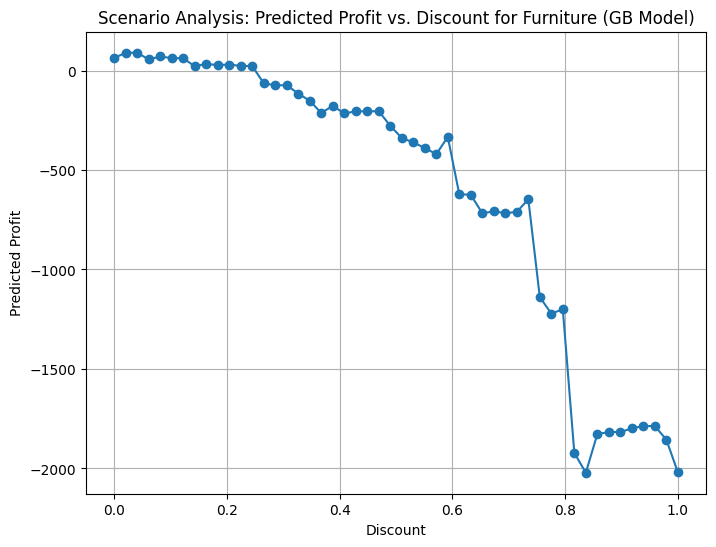

   Discount  Simulated Sales  Predicted Profit
0  0.000000       351.331200         62.877409
1  0.020408       375.231282         89.389755
2  0.040816       399.131363         89.389755
3  0.061224       423.031445         55.540885
4  0.081633       446.931527         70.630416
5  0.102041       470.831608         61.840708
6  0.122449       494.731690         61.790195
7  0.142857       518.631771         21.083296
8  0.163265       542.531853         33.423748
9  0.183673       566.431935         27.101844


,Discount,Simulated Sales,Predicted Profit
0,0.000000,351.331200,62.877409
1,0.020408,375.231282,89.389755
2,0.040816,399.131363,89.389755
3,0.061224,423.031445,55.540885
4,0.081633,446.931527,70.630416
5,0.102041,470.831608,61.840708
6,0.122449,494.731690,61.790195
7,0.142857,518.631771,21.083296
8,0.163265,542.531853,33.423748
9,0.183673,566.431935,27.101844


In [49]:
def simulate_scenario_for_category_gb(category_name, df, best_gb_model, elasticity=2, n_points=50):
    """
    Simulate predicted profit over a full discount range (0 to 1) for a given category using the Gradient Boosting model.
    
    Parameters:
      category_name: 'Office Supplies', 'Technology', or 'Furniture'
      df: the full preprocessed DataFrame (with one-hot encoded variables)
      best_gb_model: the trained Gradient Boosting model
      elasticity: assumed rate at which sales change with discount (e.g., 2 means 2% change per 0.01 discount change)
      n_points: number of discount values to simulate
      
    Returns:
      result: DataFrame containing the simulated discount, adjusted Sales, and predicted Profit.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Filter data based on the chosen category
    if category_name == 'Office Supplies':
        subset = df[df['Category_Office Supplies'] == 1]
    elif category_name == 'Technology':
        subset = df[df['Category_Technology'] == 1]
    elif category_name == 'Furniture':
        # Furniture is assumed to be the reference category: where both Office Supplies and Technology dummies are 0.
        subset = df[(df['Category_Office Supplies'] == 0) & (df['Category_Technology'] == 0)]
    else:
        print("Invalid category name provided.")
        return
    
    if subset.empty:
        print(f"No data found for {category_name}.")
        return
    
    # Select a baseline sample based on the median discount
    median_discount = subset['Discount'].median()
    baseline_sample = subset.iloc[(subset['Discount'] - median_discount).abs().argsort()[:1]].copy()
    
    print(f"\nChosen baseline sample for {category_name}:")
    print(baseline_sample[['Discount', 'Sales', 'Profit']])
    
    baseline_discount = baseline_sample['Discount'].iloc[0]
    baseline_sales = baseline_sample['Sales'].iloc[0]
    
    # Define the full discount range from 0 to 1
    discount_range = np.linspace(0, 1, n_points)
    
    # Compute change from the baseline discount
    delta = discount_range - baseline_discount
    
    # Adjust Sales using the elasticity assumption
    simulated_sales = baseline_sales * (1 + elasticity * delta)
    
    # Create a DataFrame replicating the baseline sample for each simulated discount scenario
    simulated_samples = pd.DataFrame([baseline_sample.iloc[0]] * len(discount_range))
    simulated_samples['Discount'] = discount_range
    simulated_samples['Sales'] = simulated_sales
    
    # Remove the target column so that only predictors remain for prediction
    predictors = simulated_samples.drop('Profit', axis=1)
    
    # Predict profit for each scenario using the best Gradient Boosting model
    predicted_profit = best_gb_model.predict(predictors)
    
    # Plot predicted profit vs. discount
    plt.figure(figsize=(8, 6))
    plt.plot(discount_range, predicted_profit, marker='o')
    plt.xlabel('Discount')
    plt.ylabel('Predicted Profit')
    plt.title(f'Scenario Analysis: Predicted Profit vs. Discount for {category_name} (GB Model)')
    plt.grid(True)
    plt.show()
    
    # Build a DataFrame of the results
    result = pd.DataFrame({
        'Discount': discount_range,
        'Simulated Sales': simulated_sales,
        'Predicted Profit': predicted_profit
    })
    print(result.head(10))
    return result

# Run scenario analysis for each category
simulate_scenario_for_category_gb('Office Supplies', df, best_gb_model)
simulate_scenario_for_category_gb('Technology', df, best_gb_model)
simulate_scenario_for_category_gb('Furniture', df, best_gb_model)
